## Utpalraj Kemprai

### Importing necessary libraries

In [ ]:
import os
import json
import re
from collections import Counter
from tqdm import tqdm
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import gdown
import zipfile
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

## Assignment 4

In [ ]:
file_id = '1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm'

### Downloading the corpus

In [ ]:
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'partial_dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=bb46892c-6871-4185-9a28-cf75531f9796
To: /content/partial_dataset.zip
100%|██████████| 1.00G/1.00G [00:16<00:00, 58.9MB/s]


'partial_dataset.zip'

In [ ]:
zip_path = 'partial_dataset.zip'
extract_dir = 'JSON_files'

### Extracting the corpus content from downloaded zip files

In [ ]:
def extract_zip(zip_path, extract_dir):
  '''
  Extracts the zip file to the specified directory.

  Args:
    zip_path: The path to the zip file.
    extract_dir: The directory to extract the zip file to.
  '''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

num_cores = multiprocessing.cpu_count()

with ProcessPoolExecutor(max_workers=num_cores) as executor:
  executor.submit(extract_zip, zip_path, extract_dir)

In [ ]:
def read_file(filename):
    '''
    Reads a JSON file and returns its content as a string.

    Args:
      filename: The path to the JSON file.

    Returns:
      The content of the JSON file as a string.
    '''
    with open(filename, 'r') as f:
        paper_content = json.load(f)
    abstract = ''
    if 'abstract' in paper_content:
      for content in paper_content['abstract']:
        if 'text' in content:
          abstract += content['text']

    return abstract

def read_files(directory):
    '''
    Reads all JSON files in a directory and returns their contents as a list of strings.

    Args:
      directory: The path to the directory containing the JSON files.

    Yields:
      The content of each JSON file as a string.
    '''
    filenames = (os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json'))
    with ProcessPoolExecutor() as executor:
        # Using map to process files in parallel
        for result in tqdm(executor.map(read_file, filenames)):
            yield result

Reading the corpus

In [ ]:
text_corpus = list(read_files('JSON_files/pdf_json/'))

56528it [01:02, 899.76it/s] 


In [ ]:
corpus_size = len(text_corpus)
print(f'Corpus size: {corpus_size}')

Corpus size: 56528


### Preprocessing the corpus

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def casefolding(text):
  '''
  Converts the given text to lowercase.

  Args:
    text: The input text.

  Returns:
    The text in lowercase.
  '''
  return text.lower()

In [ ]:
def tokenize_text(text):
  '''
  Tokenizes the given text.

  Args:
    text: The input text.

  Returns:
    A list of tokens.
  '''
  return word_tokenize(text)

In [ ]:
def remove_special_chars_and_numbers_from_tokenized_text(tokens, min_count = 2):
  """
  Removes numbers and special characters from a list of tokens. And then removes tokens that appear less than min_count times.

  Args:
    tokens: A list of tokens.

  Returns:
    A new list of tokens with numbers and special characters removed.
  """
  filtered_tokens = [token for token in tokens if (not re.findall("[^\u0000-\u05C0\u2100-\u214F]+",token)) and token.isalpha() and tokens.count(token) >= min_count and len(token) > 2]
  return filtered_tokens

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
  '''
  Preprocesses the text by removing special characters and numbers, converting to lowercase,
  and tokenizing the text.

  Args:
    text: The text to be preprocessed.

  Returns:
    A list of preprocessed tokens.
  '''
  text = text.lower()
  tokens = tokenize_text(text)
  tokens = remove_special_chars_and_numbers_from_tokenized_text(tokens)
  tokens = [token for token in tokens if token not in stop_words]
  return tokens

def preprocess_corpus(corpus):
  '''
  Preprocesses the corpus by applying the preprocess_text function to each document in parallel.

  Args:
    corpus: A list of documents.

  Returns:
    A list of preprocessed documents.
  '''
  with ProcessPoolExecutor() as executor:
    return list(tqdm(executor.map(preprocess_text, corpus), total=corpus_size))

Tokenizing the corpus

In [ ]:
tokenized_corpus = preprocess_corpus(text_corpus)

100%|██████████| 56528/56528 [02:29<00:00, 379.12it/s]


Only considering documents with more than 300 words

In [ ]:
tokenized_corpus_filtered = [doc for doc in tokenized_corpus if len(doc) > 300]

In [ ]:
def get_vocabulary(tokenized_corpus):
  '''
  Gets the vocabulary of the given tokenized corpus.

  Args:
    tokenized_corpus: A list of tokenized texts.

  Returns:
    A set containing the unique words in the corpus.
  '''
  vocabulary = set()
  for document in tqdm(tokenized_corpus):
    for token in document:
      vocabulary.add(token)
  return vocabulary

Getting the vocabulary of the data

In [ ]:
vocabulary = get_vocabulary(tokenized_corpus_filtered)

100%|██████████| 506/506 [00:00<00:00, 15622.74it/s]


In [ ]:
vocabulary_size = len(vocabulary)
print(f'Vocabulary size: {vocabulary_size}')

Vocabulary size: 14171


In [ ]:
vocabulary = tuple(vocabulary)

In [ ]:
word_to_index = {word: i for i, word in enumerate(vocabulary)}

In [ ]:
vocabulary

('analytical',
 'stirred',
 'goes',
 'operative',
 'lod',
 'snapshots',
 'correlation',
 'brefeldin',
 'released',
 'polymorphismus',
 'schlafen',
 'assumed',
 'incubated',
 'deletion',
 'einem',
 'zonder',
 'evolved',
 'arc',
 'miss',
 'behaviors',
 'exhibited',
 'tween',
 'substitution',
 'subject',
 'leaders',
 'picco',
 'malrotation',
 'toronto',
 'frameshifting',
 'macrodomain',
 'épuration',
 'bds',
 'robotics',
 'photochemical',
 'cumulative',
 'untersuchung',
 'participatory',
 'ozharvest',
 'pcd',
 'appearance',
 'fuses',
 'participation',
 'catalysis',
 'weighting',
 'modulus',
 'discriminating',
 'rabbit',
 'attenuate',
 'consequences',
 'changepoints',
 'facilitate',
 'dock',
 'supervisor',
 'verfü',
 'darstellt',
 'benefiting',
 'abrasive',
 'cardiovasculaire',
 'monoinfection',
 'flavonoids',
 'advocates',
 'fälle',
 'drugbank',
 'itaas',
 'vast',
 'verwendet',
 'gluten',
 'responsive',
 'concentric',
 'autodock',
 'echocardiographic',
 'kortexschichten',
 'prodrug',
 'fu

### **Model Architecture**
- **Input Layer:** One-hot encoded vector for target words of size 14171 (size ~ 10,000).
- **Embedding Layer:** Dense layer that projects the input into a 300-dimensional space.
- **Negative Sampling Layer:** Replaces naive softmax, selecting 5 negative samples.
- **Output:** Context word prediction using the learned embeddings.


In [ ]:
def generate_skipgram_pairs(tokenized_corpus, window_size=2):
    '''
    Generate (target, context) pairs from a tokenized corpus for Skip-Gram model training.

    Args:
      tokenized_corpus: List of lists, where each list is a tokenized sentence/document.
      window_size: The number of context words to consider on either side of the target word.

    Returns:
      List of tuples in the format (target, context).
    '''
    skipgram_pairs = []

    for sentence in tokenized_corpus:
        sentence_length = len(sentence)
        for i, target_word in enumerate(sentence):
            # Define the context window range
            start = max(0, i - window_size)
            end = min(sentence_length, i + window_size + 1)

            # Collect context words for the target word
            context_words = [sentence[j] for j in range(start, end) if j != i]

            # Create (target, context) pairs
            for context_word in context_words:
                skipgram_pairs.append((target_word, context_word))

    return skipgram_pairs

In [ ]:
# Generate skipgram pairs
skipgram_pairs = generate_skipgram_pairs(tokenized_corpus_filtered, window_size=2)
print(f"Generated {len(skipgram_pairs)} skipgram pairs.")

Generated 1084536 skipgram pairs.


In [ ]:
torch.manual_seed(14)
random.seed(14)
np.random.seed(14)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        '''
        Initialize the Skip-Gram model with Negative Sampling.

        Args:
          vocab_size: The size of the vocabulary.
          embedding_dim: The number of dimensions for the word embeddings.
        '''
        super(SkipGramNegSampling, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)   # Input embedding matrix (W_in)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)  # Output embedding matrix (W_out)

    def forward(self, target_word, context_word, negative_words):
        '''
        Forward pass for Skip-Gram with Negative Sampling.

        Args:
          target_word: Tensor of target word indices.
          context_word: Tensor of context word indices (positive samples).
          negative_words: Tensor of negative word indices.

        Returns:
          Positive and negative logits for the loss computation.
        '''
        # Get embeddings for target, context (positive) and negative words
        target_embedding = self.in_embeddings(target_word)  # Shape: (batch_size, embedding_dim)
        context_embedding = self.out_embeddings(context_word)  # Shape: (batch_size, embedding_dim)
        negative_embeddings = self.out_embeddings(negative_words)  # Shape: (batch_size, num_neg_samples, embedding_dim)

        # Positive sample: dot product of target and context embeddings
        pos_dot = torch.mul(target_embedding, context_embedding).sum(dim=1)  # Shape: (batch_size)

        # Negative samples: dot product of target and negative word embeddings
        neg_dot = torch.bmm(negative_embeddings, target_embedding.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, num_neg_samples)

        return pos_dot, neg_dot


In [ ]:
def neg_sampling_loss(pos_dot, neg_dot):
    '''
    Computes the loss for negative sampling.

    Args:
      pos_dot: The dot product for positive samples (target, context).
      neg_dot: The dot product for negative samples (target, negative words).

    Returns:
      The loss for the batch.
    '''
    # Positive samples loss: log(sigmoid(pos_dot))
    pos_loss = F.logsigmoid(pos_dot).mean()

    # Negative samples loss: log(sigmoid(-neg_dot))
    neg_loss = F.logsigmoid(-neg_dot).mean()

    # Total loss (negative sampling uses negative loss and positive loss together)
    return -(pos_loss + neg_loss)


In [ ]:
def generate_negative_samples(vocab_size, batch_size, num_neg_samples):
    '''
    Generate negative samples for each target word in a batch.

    Args:
      vocab_size: The size of the vocabulary.
      batch_size: The number of target words in the batch.
      num_neg_samples: The number of negative samples per target word.

    Returns:
      Tensor of negative word indices (shape: batch_size x num_neg_samples).
    '''
    negative_words = np.random.choice(vocab_size, size=(batch_size, num_neg_samples), replace=True)
    return torch.tensor(negative_words, dtype=torch.long)


In [ ]:
# Create vocabulary and mapping of words to indices
word_counts = Counter([word for sentence in tokenized_corpus_filtered for word in sentence])
vocab = [word for word, count in word_counts.items()]
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Convert word pairs to indices
def word_to_idx_pairs(skipgram_pairs):
    return [(word_to_idx[target], word_to_idx[context]) for target, context in skipgram_pairs]

# Skipgram pairs as indices
skipgram_pairs_idx = word_to_idx_pairs(skipgram_pairs)

### Training the model with SGD

In [ ]:
# Hyperparameters
embedding_dim = 300  # Dimensionality of the word embeddings
learning_rate = 1
momentum = 0.9
epochs = 20
batch_size = 256
num_neg_samples = 5  # Negative samples per positive pair

In [ ]:
# Initialize the model
model = SkipGramNegSampling(vocab_size, embedding_dim)
model.to(device)

# List to store the loss at each epoch
training_errors = []

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    random.shuffle(skipgram_pairs_idx)

    for i in range(0, len(skipgram_pairs_idx), batch_size):
        batch = skipgram_pairs_idx[i:i+batch_size]

        # Move tensors to the device (GPU)
        target_words = torch.tensor([pair[0] for pair in batch], dtype=torch.long, device=device)
        context_words = torch.tensor([pair[1] for pair in batch], dtype=torch.long, device=device)
        negative_words = generate_negative_samples(vocab_size, len(batch), num_neg_samples).to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        pos_dot, neg_dot = model(target_words, context_words, negative_words)

        # Calculate loss
        loss = neg_sampling_loss(pos_dot, neg_dot)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        total_loss += loss.item()

    # Average loss for the epoch
    avg_loss = total_loss / len(skipgram_pairs_idx)
    training_errors.append(avg_loss)  # Append the loss for this epoch

    print(f"Epoch: {epoch+1}, Loss: {avg_loss}")

Epoch: 1, Loss: 0.028393103873003284
Epoch: 2, Loss: 0.011318089698674495
Epoch: 3, Loss: 0.0074379953411022265
Epoch: 4, Loss: 0.0053514182455260935
Epoch: 5, Loss: 0.004079532749904776
Epoch: 6, Loss: 0.0032689572959027934
Epoch: 7, Loss: 0.0027142819707315228
Epoch: 8, Loss: 0.0023202036925532563
Epoch: 9, Loss: 0.0020231895309343324
Epoch: 10, Loss: 0.001804529079699014
Epoch: 11, Loss: 0.0016255984251609815
Epoch: 12, Loss: 0.0014854848756350237
Epoch: 13, Loss: 0.0013620350228905826
Epoch: 14, Loss: 0.0012721484414120498
Epoch: 15, Loss: 0.0011951210398678433
Epoch: 16, Loss: 0.0011226944400596738
Epoch: 17, Loss: 0.001065949838911408
Epoch: 18, Loss: 0.0010148558259315665
Epoch: 19, Loss: 0.0009725454255907863
Epoch: 20, Loss: 0.0009343335481041149


### Epochs vs Training Error (loss)

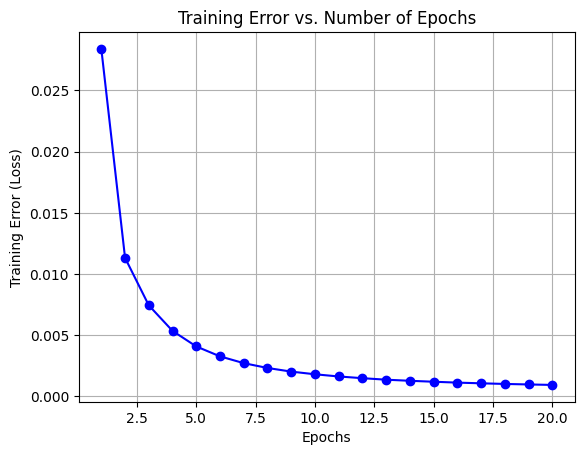

In [ ]:
# Plot the relationship between epochs and training error
plt.plot(range(1, epochs+1), training_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Training Error (Loss)')
plt.title('Training Error vs. Number of Epochs')
plt.grid(True)
plt.show()

In [ ]:
# Save the model to a file
with open('skipgram_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as skipgram_model.pkl")

Model saved as skipgram_model.pkl


### Testing word analogies

In [ ]:
def get_word_embedding(word):
  """
  Retrieves the word embedding for a given word.

  Args:
    word: The word for which to retrieve the embedding.

  Returns:
    The word embedding as a NumPy array, or None if the word is not found in the vocabulary.
  """
  if word in word_to_idx:
    word_idx = torch.tensor(word_to_idx[word], device=device)
    word_embedding = model.in_embeddings(word_idx).detach().cpu()
    return word_embedding
  else:
    return None

**Word analogy** : healthcare - prevention + phase = stage

**Explanation**:

- Removing prevention from healthcare shifts the focus away from preventive care.

- Adding phase introduces the idea of a step in a process.
- The result, stage, refers to a specific phase in a sequence, such as in treatment or disease progression.

In short, it's about shifting from preventive healthcare to a phase-oriented view, resulting in a stage in the process.


In [ ]:
embed_1 = get_word_embedding('healthcare')
embed_2 = get_word_embedding('prevention')
embed_3 = get_word_embedding('phase')

In [ ]:
# healthcare - prevention + phase = stage
a = embed_1 - embed_2 + embed_3

In [ ]:
# Get word embedding and move it to CPU for NumPy operations
# word_embedding = model.in_embeddings(a).detach().cpu()

similarities = []
for i in range(vocab_size):
    # Make sure context index is a tensor on the correct device
    context_idx = torch.tensor(i, device=device)

    # Get context embedding and move it to CPU for NumPy operations
    context_embedding = model.out_embeddings(context_idx).detach().cpu().numpy()

    cosine_sim = np.dot(a, context_embedding) / (np.linalg.norm(a) * np.linalg.norm(context_embedding))
    similarities.append((idx_to_word[i], cosine_sim))
  # Sort by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

In [ ]:
similarities[0][0]

'stage'

**word analogy** : coronavirus - covid + disease = infection

**Explanation**:

- coronavirus - covid: By subtracting covid (a specific disease caused by the coronavirus), we generalize the idea of coronavirus to any other diseases it may cause or represent, beyond just COVID-19

- \+ disease: Adding disease emphasizes the general concept of illness or health conditions caused by pathogens.

- \= infection: The result is infection, which refers to the process by which a disease spreads or develops in the body, applicable to many conditions, including but not limited to COVID-19.

In summary, this analogy generalizes from covid (a specific disease) to infection, which is a broader concept in the context of diseases caused by pathogens.

In [ ]:
embed_1 = get_word_embedding('coronavirus')
embed_2 = get_word_embedding('covid')
embed_3 = get_word_embedding('disease')
a = embed_1 - embed_2 + embed_3

In [ ]:
# Get word embedding and move it to CPU for NumPy operations
# word_embedding = model.in_embeddings(a).detach().cpu()

similarities = []
for i in range(vocab_size):
    # Make sure context index is a tensor on the correct device
    context_idx = torch.tensor(i, device=device)

    # Get context embedding and move it to CPU for NumPy operations
    context_embedding = model.out_embeddings(context_idx).detach().cpu().numpy()

    cosine_sim = np.dot(a, context_embedding) / (np.linalg.norm(a) * np.linalg.norm(context_embedding))
    similarities.append((idx_to_word[i], cosine_sim))
  # Sort by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

In [ ]:
similarities[0][0]

'infection'

## Assignment 5

Chosen word : disease

In [ ]:
word = "disease"
embedding = get_word_embedding(word)
if embedding is not None:
  print(f"Word embedding for '{word}':\n{embedding}")
else:
  print(f"Word '{word}' not found in the vocabulary.")

Word embedding for 'disease':
tensor([ 6.5200e-01, -1.9716e-01, -1.2590e-01, -4.0400e-01,  1.8954e-01,
         6.9817e-02,  7.5008e-02, -4.9190e-01,  4.0385e-02, -1.5249e-01,
         6.3250e-02,  9.7713e-02,  4.6347e-01, -2.3879e-01, -2.5807e-01,
         3.0021e-01, -3.7631e-01,  3.1456e-02, -1.2739e-02,  2.5579e-01,
         2.1644e-02,  4.9756e-01,  1.4811e-01,  1.7095e-02, -3.8120e-02,
        -7.4219e-01, -7.8383e-01,  8.5902e-01, -2.7667e-01,  1.6380e-01,
         4.4468e-01, -9.3250e-02,  3.0034e-01, -5.1525e-01,  3.8722e-01,
        -2.0226e-01,  5.0168e-04,  3.1773e-01, -7.0817e-02,  1.2967e-02,
        -5.0259e-01,  1.4460e-01,  2.0826e-02,  4.0038e-01, -3.2045e-02,
        -2.0684e-01,  3.0113e-01,  4.5830e-01,  1.8988e-01,  3.7187e-02,
         2.4395e-01,  1.1505e-01, -1.6506e-01, -5.9458e-01, -1.2655e-01,
        -2.9628e-01,  2.0720e-02,  3.3842e-01,  1.4236e-01,  2.8563e-01,
        -1.3446e-01, -4.5762e-01, -4.3459e-01,  6.4435e-01, -7.5540e-01,
        -3.9554e-01, 

### Finding similar words to the word 'disease' using $W_{in}$

In [ ]:
def get_similar_words_using_W_in(word, word_to_index, index_to_word, W_in, top_n=5):
    '''
    Finds the top-N similar words for a given word using the W_in matrix.

    Args:
      word: The word for which we want to find similar words.
      word_to_index: A dictionary mapping words to their indices.
      index_to_word: A dictionary mapping indices to their corresponding words.
      W_in: The input matrix (word embedding matrix).
      top_n: The number of similar words to return (default is 5).

    Returns:
      A list of tuples containing the similar words and their cosine similarity scores.
    '''
    word_idx = word_to_idx[word]
    word_embedding = W_in[word_idx].reshape(1, -1)  # Get the embedding for the given word

    # Calculate cosine similarity between the word and all other words
    similarities = cosine_similarity(word_embedding, W_in)[0]

    # Get the top-N most similar words
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Sort and get top-n indices
    similar_words = [(idx_to_word[idx], similarities[idx]) for idx in similar_indices]

    return similar_words


In [ ]:
word = 'disease'
similar_words_W_in = get_similar_words_using_W_in(word, word_to_idx[word], idx_to_word[word_to_idx[word]], W_in = model.in_embeddings.weight.data.cpu(), top_n=5)
print(f"Top similar words for '{word}' using W_in: {similar_words_W_in}")

Top similar words for 'disease' using W_in: [('diseases', 0.4130399), ('inflammatory', 0.34420758), ('infections', 0.34399664), ('risk', 0.32892263), ('acute', 0.3206243)]


### Finding similar words to the word 'disease' using $W_{out}$

In [ ]:
def get_similar_words_using_W_out(word, word_to_index, index_to_word, W_out, top_n=5):
    '''
    Finds the top-N similar words for a given word using the W_out matrix.

    Args:
      word: The word for which we want to find similar words.
      word_to_index: A dictionary mapping words to their indices.
      index_to_word: A dictionary mapping indices to their corresponding words.
      W_out: The output matrix.
      top_n: The number of similar words to return (default is 5).

    Returns:
      A list of tuples containing the similar words and their cosine similarity scores.
    '''
    word_idx = word_to_idx[word]
    word_embedding = W_out[word_idx].reshape(1, -1)  # Get the embedding for the given word

    # Calculate cosine similarity between the word and all other words
    similarities = cosine_similarity(word_embedding, W_out)[0]

    # Get the top-N most similar words
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Sort and get top-n indices
    similar_words = [(idx_to_word[idx], similarities[idx]) for idx in similar_indices]

    return similar_words


In [ ]:
# Example usage
similar_words_W_out = get_similar_words_using_W_out(word, word_to_idx, idx_to_word, W_out = model.out_embeddings.weight.data.cpu(), top_n=5)
print(f"Top similar words for '{word}' using W_out: {similar_words_W_out}")

Top similar words for 'disease' using W_out: [('patients', 0.36471528), ('infection', 0.3211676), ('viral', 0.3168927), ('virus', 0.29496276), ('used', 0.28112215)]


### Find similar words to the word 'disease' using $W_{avg} = \frac{W_{in} + W_{out}}{2}$

In [ ]:
def get_similar_words_avg(word, word_to_index, index_to_word, W_in, W_out, top_n=5):
    '''
    Finds the top-N similar words for a given word using the average of W_in and W_out matrices.

    Args:
      word: The word for which we want to find similar words.
      word_to_index: A dictionary mapping words to their indices.
      index_to_word: A dictionary mapping indices to their corresponding words.
      W_in: The input matrix.
      W_out: The output matrix.
      top_n: The number of similar words to return (default is 5).

    Returns:
      A list of tuples containing the similar words and their cosine similarity scores.
    '''
    word_idx = word_to_idx[word]

    # Average the W_in and W_out embeddings
    combined_embedding = ((W_in[word_idx] + W_out[word_idx]) / 2).reshape(1, -1)

    # Calculate cosine similarity between the word and all other words
    avg_matrix = (W_in + W_out) / 2
    similarities = cosine_similarity(combined_embedding, avg_matrix)[0]

    # Get the top-N most similar words
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Sort and get top-n indices
    similar_words = [(idx_to_word[idx], similarities[idx]) for idx in similar_indices]

    return similar_words

In [ ]:
similar_words_avg = get_similar_words_avg(word, word_to_idx, idx_to_word, W_in = model.in_embeddings.weight.data.cpu(), W_out = model.out_embeddings.weight.data.cpu(), top_n=5)
print(f"Top similar words for '{word}' using averaged W_in and W_out: {similar_words_avg}")

Top similar words for 'disease' using averaged W_in and W_out: [('diseases', 0.4694792), ('patients', 0.40887433), ('severe', 0.40584725), ('infection', 0.38363713), ('lung', 0.3803318)]


### Comparing the results for the word 'disease'

In [ ]:
print(f"Results using W_in: {similar_words_W_in}")
print(f"Results using W_out: {similar_words_W_out}")
print(f"Results using combined W_in and W_out: {similar_words_avg}")

Results using W_in: [('diseases', 0.4130399), ('inflammatory', 0.34420758), ('infections', 0.34399664), ('risk', 0.32892263), ('acute', 0.3206243)]
Results using W_out: [('patients', 0.36471528), ('infection', 0.3211676), ('viral', 0.3168927), ('virus', 0.29496276), ('used', 0.28112215)]
Results using combined W_in and W_out: [('diseases', 0.4694792), ('patients', 0.40887433), ('severe', 0.40584725), ('infection', 0.38363713), ('lung', 0.3803318)]


---
### Description of the outcome

The results by $W_{in}$, $W_{out}$ and $W_{avg}$ were all different for the word 'disease'. Though all had words that were somewhat related to the context of disease.

The results using each matrix differ because the word embeddings in $W_{in}$, $W_{out}$, and $W_{avg}$ capture different aspects of the relationships between words. For example:

- $W_{in}$ gives words related to "disease" such as "diseases" and "infections".

- $W_{out}$ returns less intuitively connected words like "used" and "viral", along with more connected words like "patients" and "infection", possibly because it captures how "disease" is used as context rather than the target.

- $W_{avg}$ balances both input and output embeddings, giving words like "severe" and "lung", which might reflect a broader relationship to "disease."

---

### Explanation of Results
- $W_{in}$ captures words that appear as targets of the word "disease." Words like "diseases" and "infections" are logically related since they appear in similar contexts in medical documents.
- $W_{out}$ returns words like "patients" and "infection". This might reflect how "disease" is often used in proximity to these words in the corpus, even if they are less directly related.
- $W_{avg}$ balances both input and output embeddings, hence providing words that are somewhat related to both target and context words, such as "dieases", "patients" and "severe".


###  Complexities of skipgram and CBOW model
As per the slide related to the complexities of skipgram and CBOW model shown in the class:

Complexity of skipgram with negative sampling: $O(T \cdot N \cdot C \cdot k)$

Complexity of CBOW with negative sampling: $O(T \cdot N \cdot C \cdot k)$

where

$T$ is total number of words in the corpus

$V$ is vocabulary size

$N$ is embedding size

$C$ is context window size

$k$ is number of negative samples

---

### Complexity Breakdown
The complexity $O(T \cdot N \cdot C \cdot k)$ arises from the following:
- \(T\): The number of words in the corpus, since the model must iterate through every word in training.
- \(N\): The embedding size (dimensionality of the word vectors). For each word, we need to compute \(N\)-dimensional vector operations.
- \(C\): The context window size, since we must predict for each word within the window.
- \(k\): The number of negative samples, since negative sampling approximates the softmax by updating only \(k\) negative word vectors for each training example.

### Justifying the Computational Complexity $O(T \cdot N \cdot C \cdot k)$ for Skipgram and CBOW Models with Negative Sampling

The complexity of the **Skipgram** and **Continuous Bag of Words (CBOW)** models with **negative sampling** can be broken down by analyzing each of the components involved in the training process. Let's dive into the roles of $T$, $N$, $C$, and $k$ to understand why the overall complexity is $O(T \cdot N \cdot C \cdot k)$.

---

#### **1. Total Number of Words in the Corpus (\(T\))**
- **Reasoning**: The model processes the entire corpus, iterating through every word during training.
- Both **Skipgram** and **CBOW** models are trained by iterating through each word in the training corpus.
- For each word, we either predict its surrounding context words (Skipgram) or use the surrounding context to predict the word itself (CBOW).
  
Thus, the number of words in the corpus directly affects the number of training steps, which is proportional to \(T\).

---

#### **2. Embedding Size (\(N\))**
- **Reasoning**: The dimensionality of word vectors (or embeddings) impacts the cost of each forward and backward pass.
  
In both models, each word is represented as a dense vector of size \(N\). For each prediction:
- **Skipgram**: The input word's embedding is used to predict the context words.
- **CBOW**: The context words' embeddings are used to predict the target word.

For each prediction, vector operations like dot products, gradient computations, and updates are performed on \(N\)-dimensional vectors. Hence, the number of computations per training step scales with the embedding size \(N\), as we need to update and compute gradients for embeddings in a space of dimensionality \(N\).

---

#### **3. Context Window Size (\(C\))**
- **Reasoning**: The model's complexity grows linearly with the number of context words considered.

In both models, the **context window size (\(C\))** defines how many words are used as context for each target word:
- **Skipgram**: For each target word, the model predicts each of its \(C\) surrounding words.
  - For example, if the window size is 5, the model will try to predict the 5 context words around the target word. Thus, the larger the context window size, the more predictions need to be made for each word, increasing computational cost.
- **CBOW**: For each group of \(C\) context words, the model predicts the central word. The larger the context window, the more embeddings are summed (or averaged) to form the input for prediction.
  
Hence, the cost scales linearly with \(C\) because each word (Skipgram) or target word prediction (CBOW) is associated with \(C\) surrounding words.

---

#### **4. Number of Negative Samples (\(k\))**
- **Reasoning**: Negative sampling reduces the computational cost of softmax, but still requires \(k\) negative samples per prediction.

In **negative sampling**, instead of computing the full softmax over the entire vocabulary (which would involve updating embeddings for every word in the vocabulary), the model only updates embeddings for:
- The true positive context word(s).
- \(k\) randomly chosen negative samples.

Thus, instead of a full softmax over \(V\) words (where \(V\) is the vocabulary size), the model computes the dot product and updates the parameters for only \(k+1\) words (1 positive word + \(k\) negative samples).

The number of negative samples, \(k\), dictates how many random non-context words are chosen and updated during each training step. Since each of these samples involves vector operations (dot product, gradients, etc.), the computational cost is proportional to \(k\).

---

### Putting It All Together: $O(T \cdot N \cdot C \cdot k)$

1. **\(T\)**: The model iterates through every word in the corpus (number of words = \(T\)).
2. **\(N\)**: Each word is represented as a dense vector of size \(N\), and the operations (dot products, updates) are performed on these vectors.
3. **\(C\)**: For each word, the model predicts \(C\) context words (Skipgram) or uses \(C\) context words to predict the target word (CBOW).
4. **\(k\)**: For each target-context word pair, the model uses negative sampling to approximate the softmax, updating parameters for \(k+1\) words (1 positive + \(k\) negatives).

Thus, the overall complexity per epoch is:
$
O(T \cdot N \cdot C \cdot k)
$
where:
- **\(T\)** determines how many training steps we perform.
- **\(N\)** determines the cost of each vector operation (embedding lookup, dot product, gradient update).
- **\(C\)** determines how many context words we consider for each target word (in Skipgram) or how many words we sum for predicting the target word (in CBOW).
- **\(k\)** determines the number of negative samples for each positive prediction, directly affecting the number of operations to update the embeddings.

<!-- --- -->

<!-- ### Why is Negative Sampling Efficient?

Without negative sampling, the complexity would be proportional to \(V\), where \(V\) is the vocabulary size (since we would need to compute and normalize probabilities for every word in the vocabulary). This would lead to a complexity of $O(T \cdot N \cdot C \cdot V)$, which is computationally infeasible for large vocabularies.

By introducing negative sampling, the model only needs to update a small subset of the vocabulary during each training step (1 positive word and \(k\) negative words), reducing the complexity to $O(T \cdot N \cdot C \cdot k)$, where $k$ is much smaller than $V$.

Negative sampling provides a trade-off between approximation accuracy and efficiency, allowing large models to be trained on vast corpora with reasonable computational resources. -->

---

### Conclusion:

The complexity $O(T \cdot N \cdot C \cdot k)$ reflects how the Skipgram and CBOW models scale with:
- The size of the corpus (T),
- The dimensionality of the word embeddings (N),
- The number of context words used for each target word (C),
- The number of negative samples used during training (k).

This balance allows word embedding models to be trained efficiently on large datasets without computing a full softmax over a large vocabulary, thanks to negative sampling.
